<a href="https://colab.research.google.com/github/bbchen33/Insight-project/blob/master/Job_titles_classification_using_pretrained_titles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Import the table with the ground truth (scraped + trained with job description).

In [0]:
import pandas as pd
ground_truth_combined = pd.read_csv('clean_indeed_ground_truth_new_titles_and_trained_titles_Feb5_.txt', sep = '\t')

In [3]:
len(ground_truth_combined['official job'].unique())

52

'various job' in the handlabel dataframe is the actual clients' job titles and 'official job' is the appropriate labels I assigned manually.

In [0]:
handlabel_df = pd.read_csv('jobtitle_data_handlabel_only.txt', sep = '\t')

In [52]:
handlabel_df.head(3)

,various job,official job
0,Cheif Accountant,accountant
1,SENIOR ACCOUNTANT,accountant
2,assistant accountant and procurement officer,accountant


In [53]:
len(handlabel_df['official job'].unique()) 

52

Double checking that all the jobs I handlabeled exist in the ground truth dataframe. Otherwise, the model will do poorly testing on something it hasn't been trained on.

In [0]:
for job in handlabel_df['official job'].unique():
  if job not in ground_truth_combined['official job'].unique():
    print(job)

zeugma is used to embed the text with pre-trained models such as word2vec trained with Google News.

In [9]:
!pip install --quiet zeugma

In [10]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [11]:
from zeugma.embeddings import EmbeddingTransformer
word2vec = EmbeddingTransformer('word2vec')

Using TensorFlow backend.


[==================================================] 100.0% 1662.8/1662.8MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Estimate accuracy by supplying different machine learning model using the below function.

In [13]:
from nltk.corpus import stopwords
import re
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import numpy as np
import pickle
warnings.filterwarnings('ignore',category = FutureWarning)

def remove_symbols(text):
  text = re.sub(r'([0-9]+?)', '', text) 
  text = re.sub(r'  ', ' ', text)
  text = re.sub(r'   ', ' ', text)
  text = re.sub(r'(!|"|#|\$|%|&|\'|\(|\)|\*|\+|,|-|\.|/|:|;|<|=|>|\?|@|\[|\\|\]|\^|_|`|{|\||}|~)+', ' ', text)
  text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
  return ' '.join(text)    
def accuracy_estimator(handlabeled_df, 
                       ground_truth_df, 
                       algo,
                       parameters=None, 
                       balance=False, 
                       make_cm=False,
                       save_model=False,
                       filename=None):
  if save_model:
    assert 'Give a filename for saving the model'
  handlabeled_df['various job'] = handlabeled_df['various job'].str.lower()
  handlabeled_df['various job'] = handlabeled_df['various job'].apply(lambda x:remove_symbols(x))
  handlabeled_df['various job'] = handlabeled_df['various job'].str.strip()

  combined_df = pd.concat([ground_truth_df, handlabeled_df])
  combined_df = combined_df.reset_index(drop = True)
  ground_truth_length = len(ground_truth_df)
  
  combined_df['various job'] = combined_df['various job'].values.astype('str')
  X = word2vec.transform(combined_df['various job'])
  X_train = X[:ground_truth_length]
  X_test = X[ground_truth_length:] 

  le = LabelEncoder()
  y = le.fit_transform(combined_df['official job'])
  y_train = y[:ground_truth_length]
  y_test = y[ground_truth_length:]
  clf = algo()
  
  if parameters:
    clf.set_params(**parameters)  

  if balance:
    sm = SMOTE(random_state = 1)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print('start training')
    clf.fit(X_res, y_res)
    if save_model:
      with open(filename, 'wb') as file:
        pickle.dump(clf, file)
        print('The model has been saved.')
  else:
    print('start training')
    clf.fit(X_train, y_train)
    if save_model:
      with open(filename, 'wb') as file:
        pickle.dump(clf, file)
        print('The model has been saved.')
  print('start predicting')
  
  y_pred = clf.predict(X_test)

  if make_cm:
    cm = confusion_matrix(y_test, y_pred)
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    return [accuracy_score(y_test, y_pred), cm]
  else:
    return accuracy_score(y_test, y_pred)


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Two quick tests using ground_truth_combined that I previously collected to train a new classification model and handlabel_df to validate the model.

In [63]:
from sklearn.svm import SVC
accuracy_estimator(handlabel_df, ground_truth_combined, SVC)

start training
start predicting


0.75

In [64]:
from sklearn.linear_model import LogisticRegression
accuracy_estimator(handlabel_df, ground_truth_combined, LogisticRegression)

start training
start predicting


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.7960526315789473

In [28]:
!pip install hypopt
from hypopt import GridSearch

Estimate accuracy by doing grid search using the below function.

In [0]:
from hypopt import GridSearch
def grid_search_accuracy_estimator(handlabeled_df, ground_truth_df, algo, parameters, balance=False):
  handlabeled_df['various job'] = handlabeled_df['various job'].str.lower()
  handlabeled_df['various job'] = handlabeled_df['various job'].apply(lambda x:remove_symbols(x))
  handlabeled_df['various job'] = handlabeled_df['various job'].str.strip()

  combined_df = pd.concat([ground_truth_df, handlabeled_df])
  combined_df = combined_df.reset_index(drop = True)
  ground_truth_length = len(ground_truth_df)
  
  combined_df['various job'] = combined_df['various job'].values.astype('str')
  X = word2vec.transform(combined_df['various job'])
  X_train = X[:ground_truth_length]
  X_test = X[ground_truth_length:] 

  le = LabelEncoder()
  y = le.fit_transform(combined_df['official job'])
  y_train = y[:ground_truth_length]
  y_test = y[ground_truth_length:]
  gs = GridSearch(model = algo(), param_grid = parameters)

  if balance:
    sm = SMOTE(random_state = 1)
    X_res, y_res = sm.fit_resample(X_train, y_train)
    print('start training with balanced data')
  else:
    print('start training with unbalanced data')
  gs.fit(X_train, y_train, X_test, y_test)
  for z in gs.get_param_scores()[:2]:
    p, s = z
  return [p, s]

A quick grid search using SVM

In [33]:
params = [
          {'C':[0.1, 1, 10],
           'gamma':[0.1, 1, 10],
           'kernel':['rbf','sigmoid','poly']}
]
gs1 = grid_search_accuracy_estimator(handlabel_df, ground_truth_combined, SVC, parameters=params, balance = True)

start training with balanced data


100%|██████████| 27/27 [05:15<00:00, 11.68s/it]


In [34]:
print(gs1)

[{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}, 0.756578947368421]


A quick search using logistic regression

In [72]:
from sklearn.linear_model import LogisticRegression
params = [
          {'max_iter':[200, 300, 400],
           'C':[1,10,100]}

]
gs2 = grid_search_accuracy_estimator(handlabel_df, ground_truth_combined, LogisticRegression, parameters=params, balance = True)

start training with balanced data


 33%|███▎      | 3/9 [00:32<01:22, 13.68s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
 67%|██████▋   | 6/9 [01:22<00:46, 15.64s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver o

In [73]:
print(gs2)

[{'C': 1, 'max_iter': 300}, 0.7960526315789473]


Reusing the accuracy_estimator function with the best parameters obtained to get the confusion matrix and save the model with the accuracy_estimator method.

In [86]:
best_accuracy_data = accuracy_estimator(handlabel_df, ground_truth_combined, LogisticRegression, parameters={'C': 1, 'max_iter': 300}, save_model = True, filename = 'LR_optimized_model', make_cm = True)

start training
The model has been saved.
start predicting


In [88]:
best_accuracy_data[0]

0.7960526315789473

In [80]:
!ls

clean_indeed_ground_truth_new_titles_and_trained_titles_Feb5_.txt
jobtitle_data_handlabel_only.txt
LR_optimized_model
sample_data


LS_optimized_model has been saved.

In [0]:
files.download('LR_optimized_model')

In [0]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar
import numpy as np
def plot_confusion_matrix(handlabel_df, cm_array):
  le = LabelEncoder()
  classes = handlabel_df['official job'].unique()
  le.fit_transform(handlabel_df['official job'])
  plt.figure(figsize=(20, 20))
  plt.imshow(cm_array, interpolation = 'nearest', cmap = 'Greens')
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 90)
  plt.yticks(tick_marks, classes)
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  colorbar()
  plt.rcParams.update({'font.size': 20})

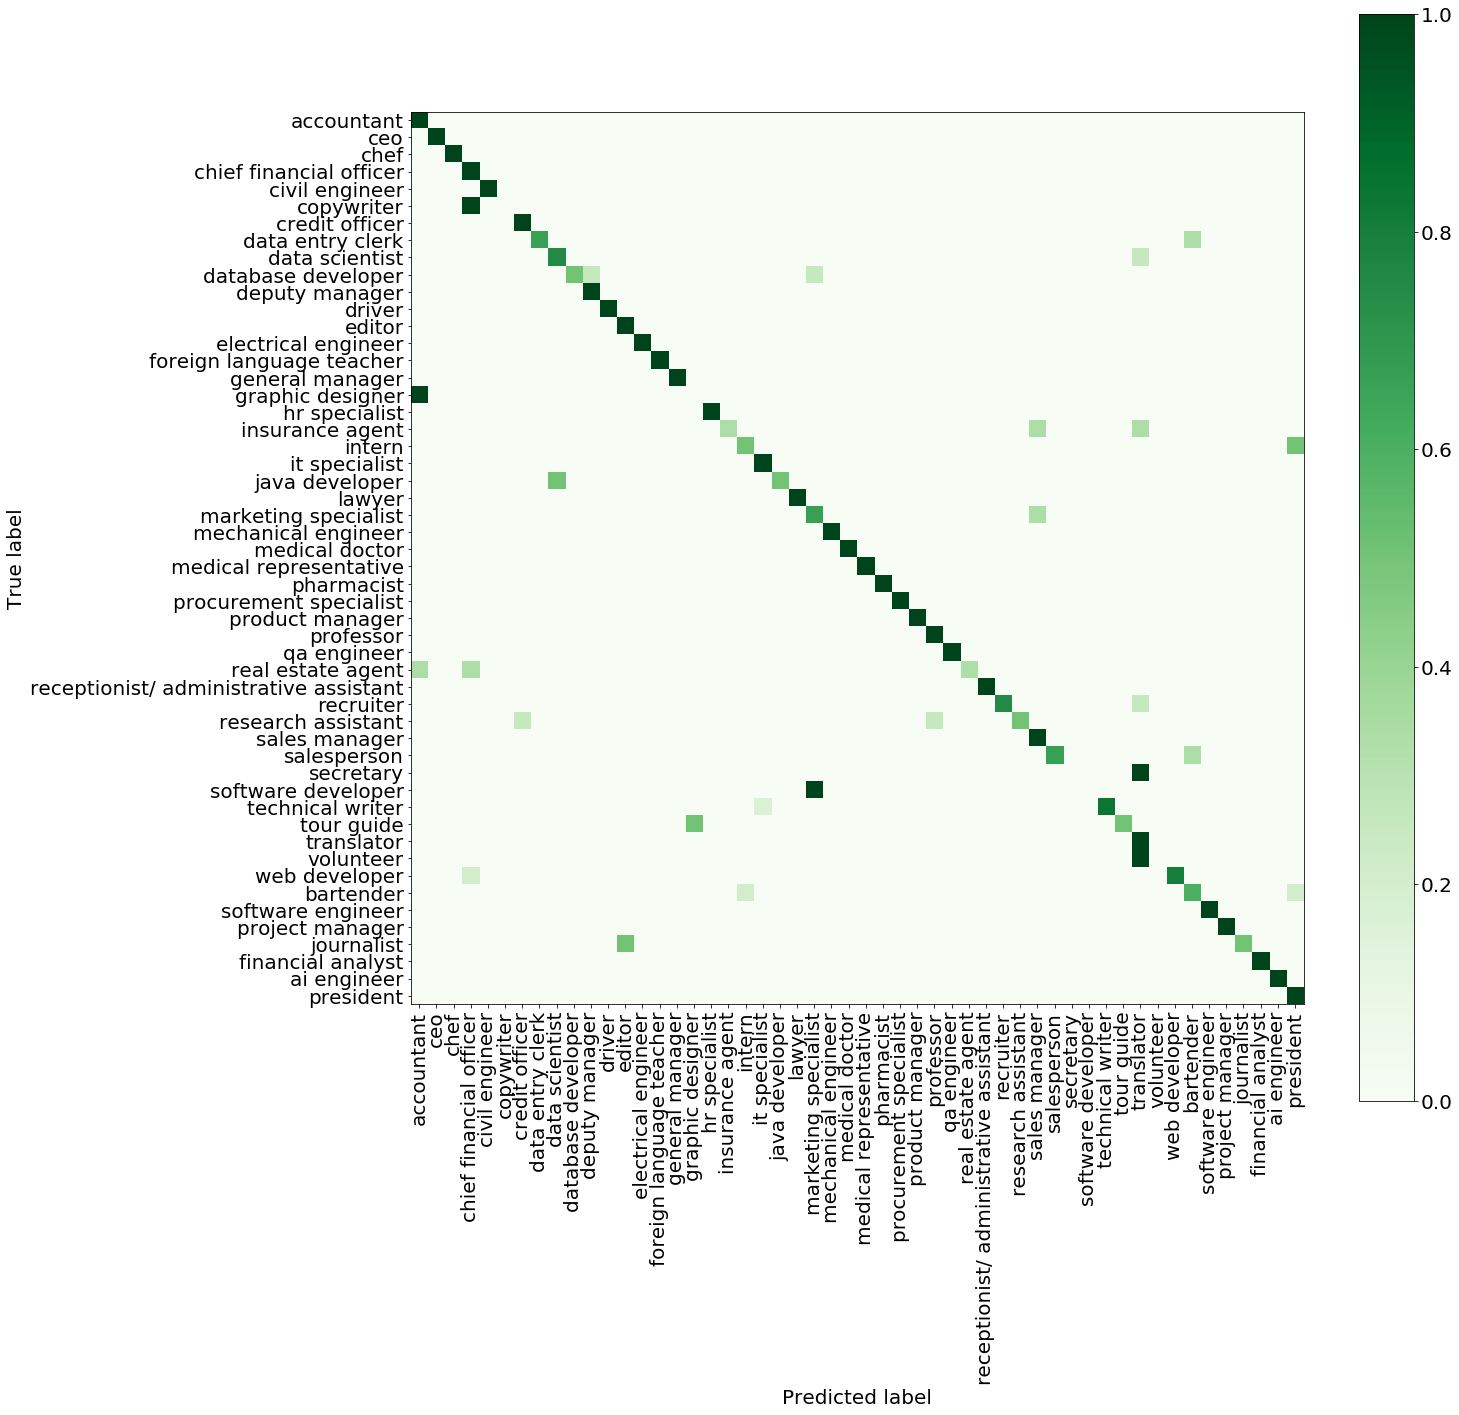

In [152]:
cm = best_accuracy_data[1]
plot_confusion_matrix(handlabel_df, cm)

In [0]:
import matplotlib.pyplot as plt

def find_bad_prediction(handlabel_df, cm_array, plot_cm = True):
  le = LabelEncoder()
  classes = handlabel_df['official job'].unique()
  le.fit(handlabel_df['official job'])
  num_classes = len(classes)
  bad_data_index = [] # for collecting the job pairs that get confused. every pair inside a list. 
  bad_data_index_joined = [] # for collecting the index for jobs that had bad prediction score
  for i in range(num_classes):
    for j in range(num_classes):
      if cm_array[i, j] > 0.5 and i != j:
        bad_data_index.append([i, j])
        bad_data_index_joined.append(i)
        if j not in bad_data_index_joined:
          bad_data_index_joined.append(j)

  confused_jobs = []
  for index in bad_data_index:
    confused_jobs.append(le.inverse_transform(index))

  bad_data_index_joined.sort()
  if plot_cm:
    bad_data_index_joined.sort()
    cm1 = cm_array[bad_data_index_joined,:] # using the bad data index to get data with specific index
    cm2 = cm1[:, bad_data_index_joined] 
    bad_titles = le.inverse_transform(bad_data_index_joined)
    pic_size = len(bad_data_index_joined)*1.5
    plt.figure(figsize=(pic_size, pic_size))
    plt.imshow(cm2, interpolation = 'nearest', cmap = 'Greens')
    tick_marks = np.arange(len(bad_titles))
    plt.xticks(tick_marks, bad_titles, rotation = 90)
    plt.yticks(tick_marks, bad_titles)
    plt.rcParams.update({'font.size': 20})
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    colorbar()
  return f'The job pairs that are hard to predict: {confused_jobs}'

"The job pairs that are hard to predict: [array(['chief financial officer', 'ceo'], dtype=object), array(['financial analyst', 'accountant'], dtype=object), array(['real estate agent', 'sales manager'], dtype=object), array(['receptionist/ administrative assistant', 'it specialist'],\n      dtype=object), array(['salesperson', 'sales manager'], dtype=object)]"

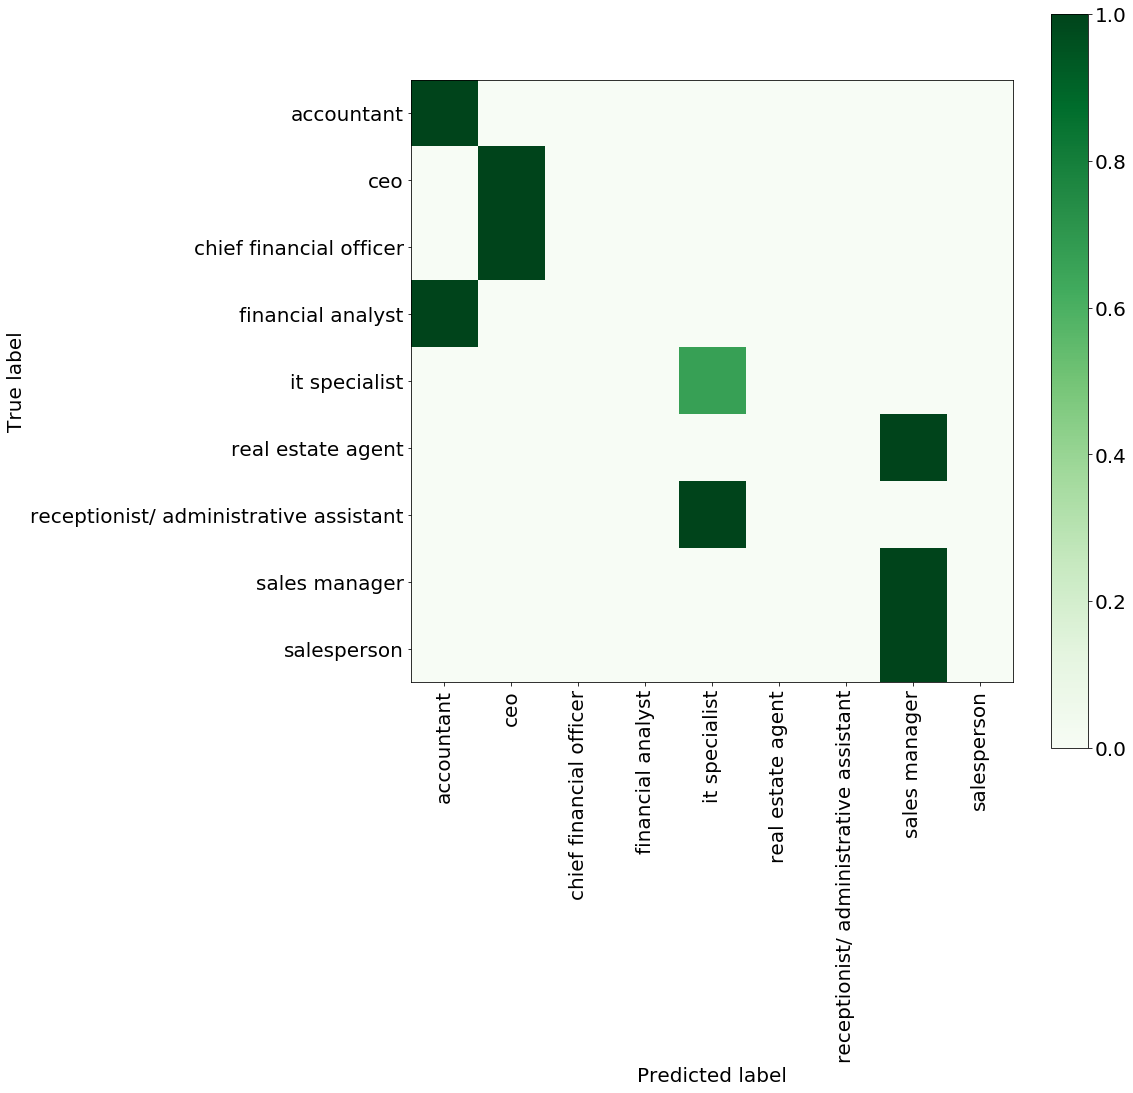

In [154]:
find_bad_prediction(handlabel_df, cm)